In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import ConfusionMatrixDisplay
from langdetect import detect

In [2]:
# Load the data
MIN_NUMBER_TO_REMOVE = 350
data = pd.read_excel('Tagged tickets - all time - Optics -2023-07-14-09-18-45.xlsx')[['Customer Description', 'Subject', 'Tag: Issue Details']]

In [3]:
# Get list of less frequent tags
fa = data['Tag: Issue Details'].value_counts()
all_list = fa.index.tolist()
lis = [all_list[i] for i in range(fa.size) if fa.iloc[i] <= MIN_NUMBER_TO_REMOVE]

In [4]:
# Drop rows with less frequent tags
for tag in lis:
    data = data.drop(data[data['Tag: Issue Details'] == tag].index)

In [5]:
# Fill missing values
for column in data.columns:
    data[column].fillna("nwg", inplace=True)

In [6]:
# Define a function to clean the documents
def clean_docs(docs, language):
    stops = stopwords.words(language)
    with open("extrastops.txt", "r") as f:
        extra = f.read().split()
    stops.extend(extra)
    final_docs = []
    for doc in docs:
        doc = re.sub(r"\(.*?\)", "()", doc)
        doc = doc.translate(str.maketrans("", "", string.punctuation))
        doc = re.sub(r"\d{1,4}[\/.-]\d{1,4}[\/.-]\d{1,4}", "", doc)
        doc = ' '.join([i for i in doc.split() if '@' not in i])
        words = word_tokenize(doc.lower())
        words = [word for word in words if word.isalpha() and word not in stops]
        final_docs.append(' '.join(words) if words else 'nwg')
    return final_docs

In [7]:
# Clean the documents for different languages
languages = ["english", "turkish", "portuguese", "spanish"]
for lang in languages:
    data['Customer Description'] = clean_docs(data['Customer Description'], language=lang)
    data['Subject'] = clean_docs(data['Subject'], language=lang)

In [8]:
# Feature engineering
data['Word Count'] = data['Subject'].apply(lambda text: len(text.split()))
data['Avg Sentence Length'] = data['Subject'].apply(lambda text: np.mean([len(sentence.split()) for sentence in text.split('.') if sentence.strip()]))
data['Word Count'] = data['Customer Description'].apply(lambda text: len(text.split()))
data['Avg Sentence Length'] = data['Customer Description'].apply(lambda text: np.mean([len(sentence.split()) for sentence in text.split('.') if sentence.strip()]))

In [9]:
# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data['Subject'] + " " + data['Customer Description'])

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['Tag: Issue Details'], test_size=0.1)

In [11]:
# Train the model
model = LinearSVC(C=0.1, dual=False)
model.fit(X_train, y_train)

LinearSVC(C=0.1, dual=False)

In [12]:
# Predict on test data
y_pred_test = model.predict(X_test)

In [13]:
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')

In [14]:
print("Accuracy statistics for the subset of data:")
print("Accuracy rate: {:.2f}%".format(accuracy * 100))
print("F1 score on test set: {:.2f}".format(f1))

Accuracy statistics for the subset of data:
Accuracy rate: 59.82%
F1 score on test set: 0.56


In [15]:
correct_predictions = accuracy * len(y_test)
total_predictions = len(y_test)
print("Correct predictions ratio: {}/{}".format(int(correct_predictions), total_predictions))

Correct predictions ratio: 201/336


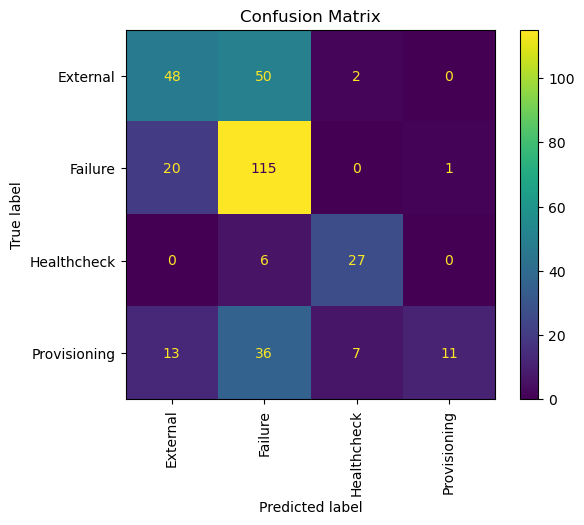

In [16]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
display_labels = np.unique(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot(cmap='viridis', include_values=True, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [17]:
print("\nClassification Report:")
print("------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_test, zero_division=1))


Classification Report:
------------------------------------------------------------------------
              precision    recall  f1-score   support

    External       0.59      0.48      0.53       100
     Failure       0.56      0.85      0.67       136
 Healthcheck       0.75      0.82      0.78        33
Provisioning       0.92      0.16      0.28        67

    accuracy                           0.60       336
   macro avg       0.70      0.58      0.57       336
weighted avg       0.66      0.60      0.56       336



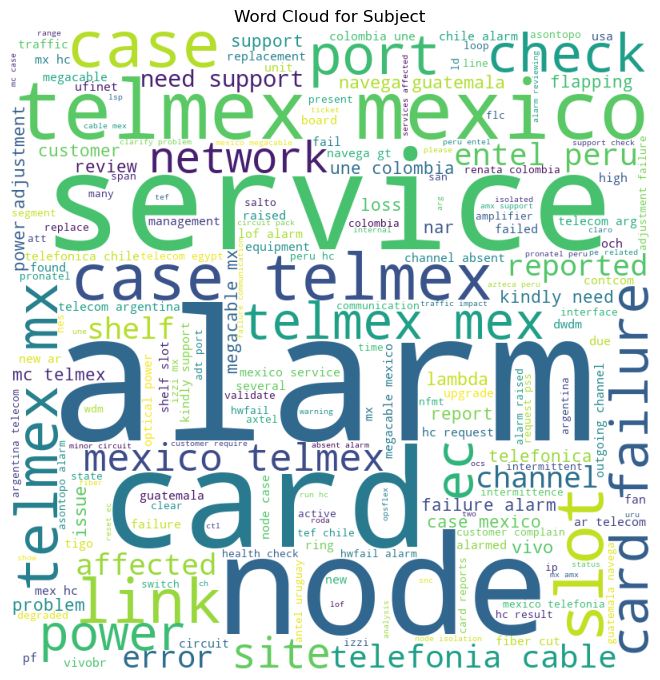

In [18]:
# Create word clouds
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS, min_font_size=10).generate(" ".join(data['Subject']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)
plt.title("Word Cloud for Subject")
plt.show()

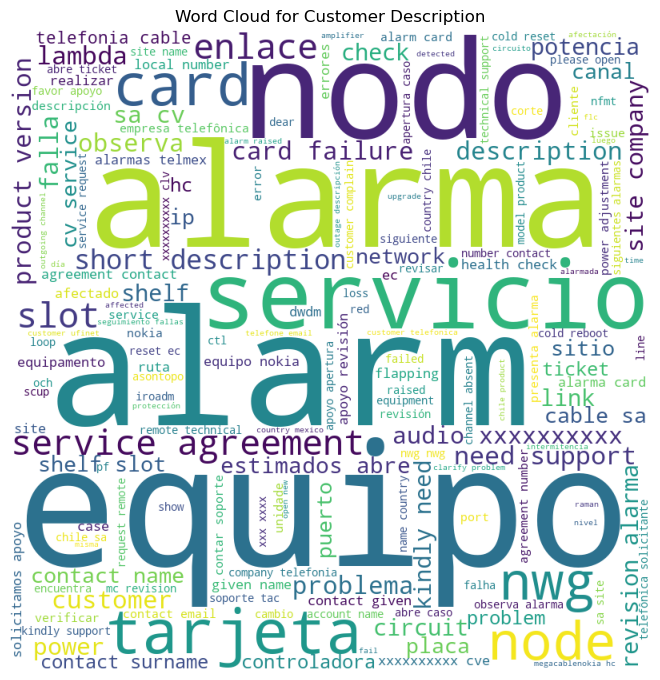

In [19]:
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS, min_font_size=10).generate(" ".join(data['Customer Description']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)
plt.title("Word Cloud for Customer Description")
plt.show()